**Group: g16**

- anderdav@students.zhaw.ch
- goodnic1@students.zhaw.ch
- janick.rueegger@students.fhnw.ch
- neyerjoh@students.zhaw.ch

In [1]:
import glob
import os
import string

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

2022-05-03 19:30:37.542934: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-03 19:30:37.542978: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Load Data

The names can be found in text files in a src directory, one file per language.

In the following you can find some utilities to load the data into pandas data frames. 

We will restrict to some common European languages. 

With the given selection, we will identify all the occurring characters and initialize an alphabet.<br>
For this alphabet, we will use a one-hot-encoding to map them into a vector space representation. 

Foresee a suitable character for the end of the word, e.g. 'END'.

In [2]:
srcdir = 'data/names'
languages = ["English","French","Italian","German","Spanish"]

In [3]:
# inspect the data directory
def findFiles(path): 
    return glob.glob(path)

In [4]:
print('\n'.join(findFiles(os.path.join(srcdir,'*.txt'))))

data/names/Czech.txt
data/names/Irish.txt
data/names/Dutch.txt
data/names/Vietnamese.txt
data/names/Chinese.txt
data/names/Japanese.txt
data/names/Italian.txt
data/names/Greek.txt
data/names/Scottish.txt
data/names/Portuguese.txt
data/names/Polish.txt
data/names/Arabic.txt
data/names/Spanish.txt
data/names/French.txt
data/names/Korean.txt
data/names/English.txt
data/names/German.txt
data/names/Russian.txt


In [5]:
# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return lines

def load_data(srcdir, categories=None):
    names_list = []
    for filename in findFiles(os.path.join(srcdir,'*.txt')):
        category = os.path.splitext(os.path.basename(filename))[0]
        if not categories or category in categories: 
            names = readLines(filename)
            names_list.extend([(name,category) for name in names])
    df = pd.DataFrame(names_list)
    df.columns = ["name","lang"]
    return df

In [6]:
names = load_data(srcdir,categories=languages)
names.head()

,name,lang
0,Abandonato,Italian
1,Abatangelo,Italian
2,Abatantuono,Italian
3,Abate,Italian
4,Abategiovanni,Italian


In [8]:
maxlen = np.max([len(name) for name in names.name])
print("Maximum name length: ", maxlen)

Maximum name length:  18


In [9]:
alphabet = sorted(list(set(''.join([name for name in names.name]))))
alphabet.append('END')
len_alphabet = len(alphabet)
char_index = dict((c, i) for i, c in enumerate(alphabet))
print("Size of alphabet: ",len_alphabet)
print(alphabet)

Size of alphabet:  74
[' ', "'", 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'Á', 'É', 'ß', 'à', 'á', 'ä', 'ç', 'è', 'é', 'ê', 'ì', 'í', 'ñ', 'ò', 'ó', 'ö', 'ù', 'ú', 'ü', 'END']


In [10]:
names.groupby('lang')['name'].count()/len(names)

lang
English    0.646230
French     0.048802
German     0.127555
Italian    0.124912
Spanish    0.052502
Name: name, dtype: float64

### Vector Representations

Now construct the vector representation by using one-hot-vectors. 

In [11]:
language_to_index = {country:index for index,country in enumerate(names.lang.unique())}
index_to_language = {index:country for index,country in enumerate(names.lang.unique())}

def onehot(i, length):
    v = np.zeros(length);
    v[i] = 1
    return v

def name_representation(name, maxlen):
    ### START YOUR CODE
    name_trunc = str(name)[0:maxlen]
    size = len(char_index)
    vector = [onehot(char_index[j], size) for j in str(name)]
    # fill the rest with 
    for k in range(0,maxlen - len(str(name))):
        vector.append(onehot(char_index['END'], size))
    return vector
    ### START YOUR CODE

def lang_representation(language, language_to_index):
    y = np.zeros(len(language_to_index))
    y[language_to_index[language]]=1
    return y

def lang_from_output(score):
    return index_to_language[np.argmax(score)]

def predict(name, model):
    score = model.predict(np.array([name_representation(name, maxlen)]))[0]
    return lang_from_output(score)

### Prepare train/test

Split the data into train/test

Shuffle the data

Transform the names data into a suitable vector respresentation:
* names into numpy arrays of shape (*,maxlen,len_alphabet)
* language into numpy array of shape (*,len(languages))



In [12]:
test_split = 0.2

### START YOUR CODE
# Shuffle and split names data

train, test = train_test_split(names, test_size=test_split)

### END YOUR CODE

In [13]:
### START YOUR CODE

# Map train and test data into vector space (one-hot-vectors)

X_train = np.asarray([name_representation(name, maxlen) for name in train.name])
Y_train = np.asarray([lang_representation(lang, language_to_index) for lang in train.lang])

X_test = np.asarray([name_representation(name, maxlen) for name in test.name])
Y_test = np.asarray([lang_representation(lang, language_to_index) for lang in test.lang])

### END YOUR CODE

Possibly, pack the data into a Dataset (e.g. when working with in PyTorch)

### Define and Train Model: Single Layer with SimpleRNN

Create an RNN consisting of a single layer with a SimpleRNN (keras) and a softmax.

Then train the model. Play with different number of hidden units in the layer to obtain a good accuracy.

In [37]:
### START YOUR CODE

# SimpleRNN, single layer with tf.keras....

n_hidden = 64

simple_rnn = Sequential()
simple_rnn.add(SimpleRNN(units=n_hidden, input_shape=(maxlen, len_alphabet)))
simple_rnn.add(Dense(len(languages), activation="softmax"))
simple_rnn.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

simple_rnn.summary()

### END YOUR CODE

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_5 (SimpleRNN)    (None, 64)                8896      
                                                                 
 dense_5 (Dense)             (None, 5)                 325       
                                                                 
Total params: 9,221
Trainable params: 9,221
Non-trainable params: 0
_________________________________________________________________


In [40]:
### START YOUR CODE
batch_size = 128
nepochs = 50

log = simple_rnn.fit(X_train, Y_train, batch_size=batch_size, epochs=nepochs, validation_data=(X_test, Y_test))

### END YOUR CODE

Epoch 1/50
36/36 [==============================] - 0s 11ms/step - loss: 0.1093 - accuracy: 0.9588 - val_loss: 1.0969 - val_accuracy: 0.7438
Epoch 2/50
36/36 [==============================] - 0s 6ms/step - loss: 0.0747 - accuracy: 0.9729 - val_loss: 1.1044 - val_accuracy: 0.7465
Epoch 3/50
36/36 [==============================] - 0s 5ms/step - loss: 0.0668 - accuracy: 0.9731 - val_loss: 1.1029 - val_accuracy: 0.7421
Epoch 4/50
36/36 [==============================] - 0s 5ms/step - loss: 0.0630 - accuracy: 0.9736 - val_loss: 1.1112 - val_accuracy: 0.7447
Epoch 5/50
36/36 [==============================] - 0s 6ms/step - loss: 0.0601 - accuracy: 0.9736 - val_loss: 1.1105 - val_accuracy: 0.7456
Epoch 6/50
36/36 [==============================] - 0s 5ms/step - loss: 0.0585 - accuracy: 0.9733 - val_loss: 1.1217 - val_accuracy: 0.7430
Epoch 7/50
36/36 [==============================] - 0s 6ms/step - loss: 0.0568 - accuracy: 0.9716 - val_loss: 1.1337 - val_accuracy: 0.7438
Epoch 8/50
36/36 [=

#### Findings

In [25]:
# Add plotting function
def plot_loss_acc(log):
    f = plt.figure(figsize=(12,4))
    ax1 = f.add_subplot(121)
    ax2 = f.add_subplot(122)
    ax1.plot(log.history['loss'], label='Training loss')
    ax1.plot(log.history['val_loss'], label='Testing loss')
    ax1.legend()
    ax1.grid()
    ax2.plot(log.history['accuracy'], label='Training acc')
    ax2.plot(log.history['val_accuracy'], label='Testing acc')
    ax2.legend()
    ax2.grid()

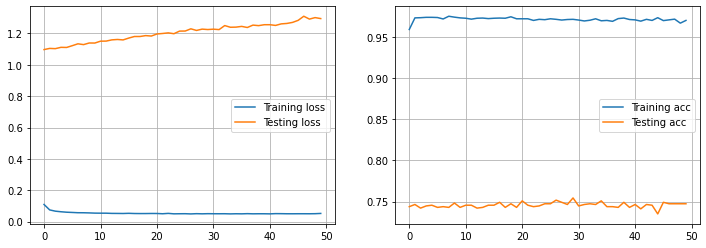

In [41]:
plot_loss_acc(log)

The model starts to overfit very fast. Even with increased number of hidden layers, the everything starts to go south after around 10 epochs. It only starts to get better after around 512 hidden layers. Increasing the batch size leads to faster overfitting. But all in all the test accuracy stays always around 75%.

### Implement Model with several SimpleRNN Layers

In [69]:
### START YOUR CODE
n_hidden = 64

model = Sequential()
model.add(SimpleRNN(units=n_hidden, input_shape=(maxlen, len_alphabet), return_sequences=True))
model.add(SimpleRNN(units=n_hidden, return_sequences=True))
model.add(SimpleRNN(units=n_hidden, return_sequences=False))
model.add(Dense(len(languages), activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.summary()

### END YOUR CODE

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_24 (SimpleRNN)   (None, 18, 64)            8896      
                                                                 
 simple_rnn_25 (SimpleRNN)   (None, 18, 64)            8256      
                                                                 
 simple_rnn_26 (SimpleRNN)   (None, 64)                8256      
                                                                 
 dense_11 (Dense)            (None, 5)                 325       
                                                                 
Total params: 25,733
Trainable params: 25,733
Non-trainable params: 0
_________________________________________________________________


In [50]:
### START YOUR CODE

batch_size = 128
nepochs = 50

stacked_log = model.fit(X_train, Y_train, batch_size=batch_size, epochs=nepochs, validation_data=(X_test, Y_test))

### END YOUR CODE

Epoch 1/50
36/36 [==============================] - 2s 33ms/step - loss: 1.1412 - accuracy: 0.6196 - val_loss: 0.9857 - val_accuracy: 0.6646
Epoch 2/50
36/36 [==============================] - 1s 14ms/step - loss: 0.8896 - accuracy: 0.6976 - val_loss: 0.8358 - val_accuracy: 0.7060
Epoch 3/50
36/36 [==============================] - 1s 15ms/step - loss: 0.7496 - accuracy: 0.7396 - val_loss: 0.8048 - val_accuracy: 0.6998
Epoch 4/50
36/36 [==============================] - 1s 17ms/step - loss: 0.6673 - accuracy: 0.7661 - val_loss: 0.7144 - val_accuracy: 0.7333
Epoch 5/50
36/36 [==============================] - 1s 16ms/step - loss: 0.6272 - accuracy: 0.7789 - val_loss: 0.6940 - val_accuracy: 0.7491
Epoch 6/50
36/36 [==============================] - 1s 15ms/step - loss: 0.5843 - accuracy: 0.7916 - val_loss: 0.6653 - val_accuracy: 0.7579
Epoch 7/50
36/36 [==============================] - 1s 17ms/step - loss: 0.5839 - accuracy: 0.7868 - val_loss: 0.6475 - val_accuracy: 0.7623
Epoch 8/50
36

#### Findings


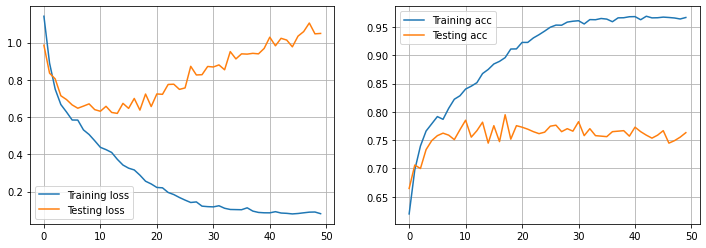

In [51]:
plot_loss_acc(stacked_log)

Again, the model easily overfits. The performance is very much comparable to a singel layer approach.

### Class Imbalance Handling

Choose a method to address the class imbalance seen in the given example.
- minority resampling 
- class weights in the loss

Implement it and incorporate it in the training.
Evaluate the results and compare it with the results obtained with the unbalanced training.  

In [52]:
from imblearn.over_sampling import SMOTE

In [54]:
sm = SMOTE()

X_len, nx, ny = X_train.shape
X_train_res, y_train_res = sm.fit_resample(X_train.reshape(X_len, nx*ny), Y_train)

In [59]:
X_new_len, _ = X_train_res.shape

X_train_res = X_train_res.reshape(X_new_len, 18, 74)

In [70]:
### START YOUR CODE

batch_size = 32
nepochs = 50

stacked_log = model.fit(X_train_res, y_train_res, batch_size=batch_size, epochs=nepochs, validation_data=(X_test, Y_test))

### END YOUR CODE

Epoch 1/50
460/460 [==============================] - 7s 11ms/step - loss: 0.9364 - accuracy: 0.6347 - val_loss: 0.9573 - val_accuracy: 0.5968
Epoch 2/50
460/460 [==============================] - 5s 11ms/step - loss: 0.4939 - accuracy: 0.8237 - val_loss: 0.8989 - val_accuracy: 0.6532
Epoch 3/50
460/460 [==============================] - 5s 11ms/step - loss: 0.3505 - accuracy: 0.8772 - val_loss: 0.9168 - val_accuracy: 0.6708
Epoch 4/50
460/460 [==============================] - 5s 11ms/step - loss: 0.2877 - accuracy: 0.9018 - val_loss: 0.8944 - val_accuracy: 0.7121
Epoch 5/50
460/460 [==============================] - 5s 11ms/step - loss: 0.2449 - accuracy: 0.9159 - val_loss: 1.0197 - val_accuracy: 0.6717
Epoch 6/50
460/460 [==============================] - 5s 11ms/step - loss: 0.2188 - accuracy: 0.9256 - val_loss: 1.0052 - val_accuracy: 0.6998
Epoch 7/50
460/460 [==============================] - 5s 11ms/step - loss: 0.2053 - accuracy: 0.9273 - val_loss: 0.9487 - val_accuracy: 0.7262

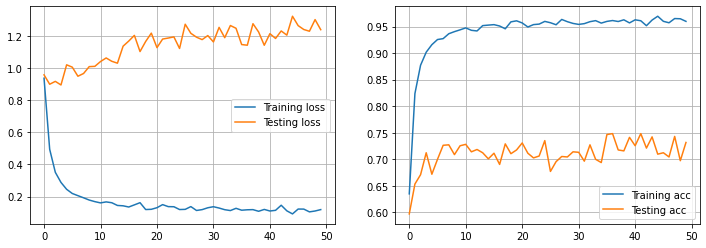

In [71]:
plot_loss_acc(stacked_log)

Even with the resampling, the model starts to overfit super fast. The final performance seems to be very comparable.